# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57456, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57456,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 958)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

21.195404

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.20273925

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57456


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[480 480 480 480 480]
 [700 764 295 431 715]
 [289 289 289 289 289]
 [986 986 986 986 399]
 [396 396 396 396 396]]
[[480]
 [700]
 [289]
 [986]
 [396]]
[[0.99999976 0.8313681  0.7500237  0.74176365 0.7102001 ]
 [1.         0.8676938  0.8310141  0.8301102  0.82937723]
 [1.         0.7493426  0.717526   0.70994186 0.6754047 ]
 [1.0000002  0.84481233 0.84381795 0.8401445  0.78210247]
 [1.         0.91339505 0.8586768  0.8549667  0.84902453]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57456,), (57456,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([480, 700, 289, 986, 396, 889, 232, 851, 157,  28]),
 array([480, 700, 289, 986, 396, 889, 232, 851, 157,  28]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([ 265,  572,  607,    8,  199,  347, 1089,   48,  301,  671]),
 array([ 265,  572,  607,    8,  199,  347, 1089,   48,  301,  671]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

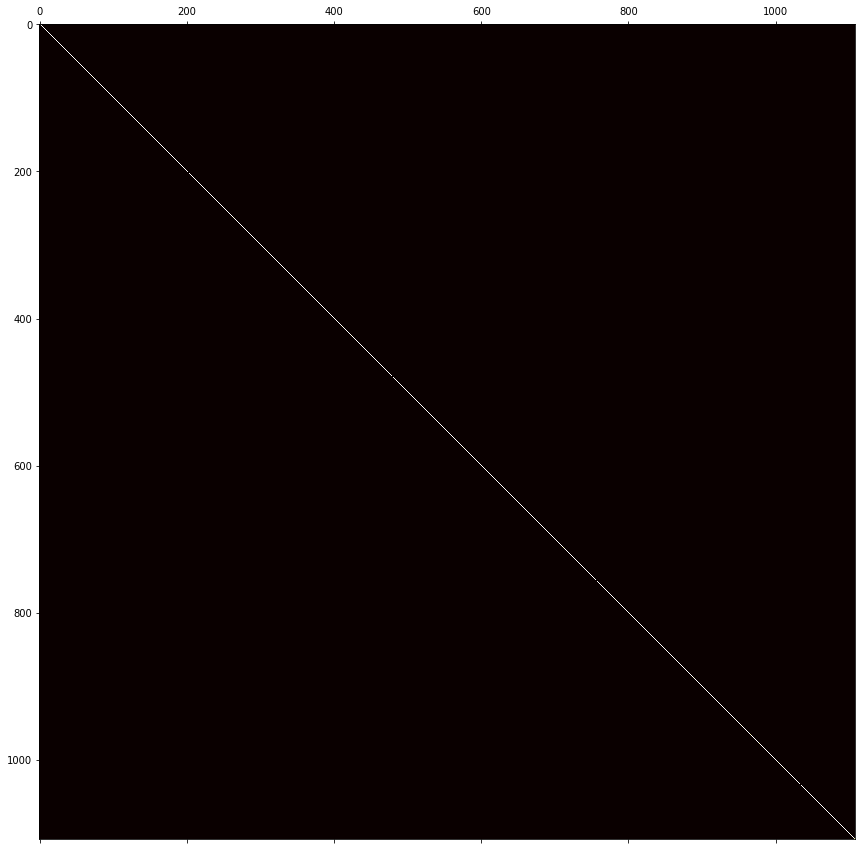

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [21]:
xq.max()

20.612173

In [22]:
faiss.normalize_L2(xq)

In [23]:
xq.max()

0.2057635

In [24]:
D_valid, I_valid = index.search(xq, k) # actual search

In [25]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [26]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [27]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[459 309 810 309 459]
 [ 91 581  70 673 295]
 [503 302 302 302 302]
 [503 810 309 505 459]
 [624 102 295 274 295]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.8661469  0.84028375 0.8335658  0.8072866  0.8043731 ]
 [0.76787543 0.7675208  0.7661506  0.7648058  0.7535333 ]
 [0.80490327 0.788762   0.7529573  0.7477083  0.74641216]
 [0.7566826  0.7141967  0.69146717 0.6911367  0.6741551 ]
 [0.8247676  0.8172062  0.8141742  0.80209005 0.8004148 ]]


In [28]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 427  427  427 1005 1061]
 [  71  107  208  176  882]
 [ 824  824  107 1054  560]
 [ 993   79  993  156  261]
 [ 836    9  403  455  509]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.9012053  0.86603415 0.812709   0.77663267 0.7489922 ]
 [0.80383694 0.767476   0.75600636 0.7385333  0.7321533 ]
 [0.8486836  0.83382356 0.7615961  0.7475797  0.7472173 ]
 [0.78835607 0.75790405 0.75399816 0.7365214  0.720442  ]
 [0.73979247 0.6937581  0.69076216 0.68791234 0.6807757 ]]


In [29]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [30]:
I_valid[:,0]

array([459,  91, 503, ..., 824, 993, 836])

In [31]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [32]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

5109

In [33]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.33012406306539155

In [34]:
valid_correct = np.equal(I_valid[:,0], yq)

In [35]:
valid_correct

array([False, False,  True, ...,  True, False, False])

In [36]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [37]:
cm = confusion_matrix(I_valid[:,0], yq)

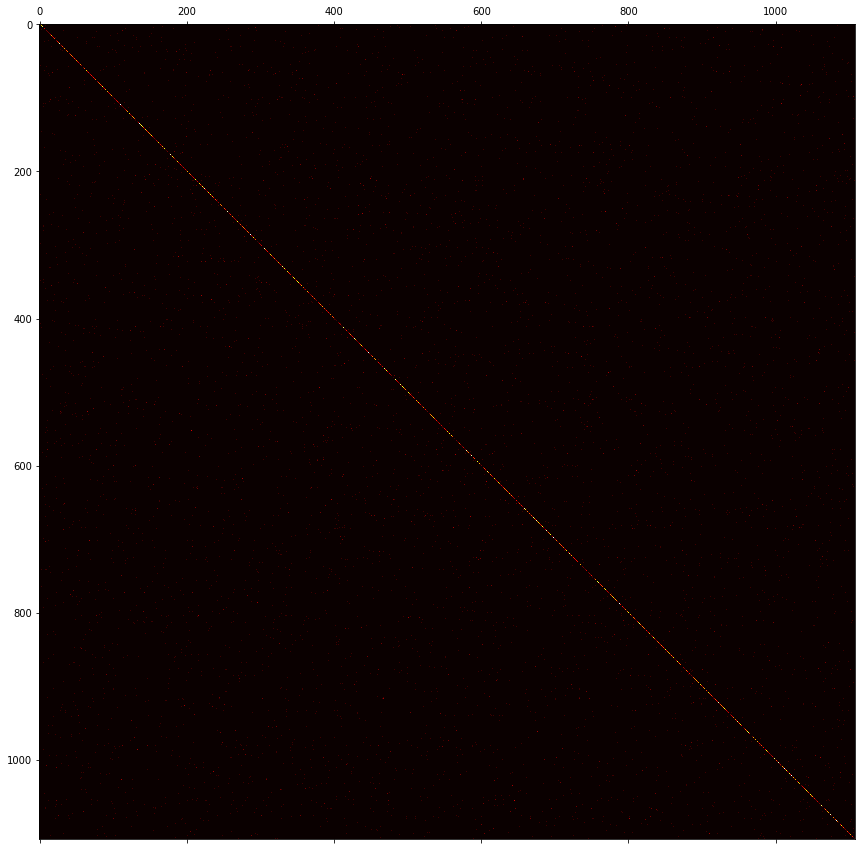

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [39]:
xq_test = np.load('pred/feats_test.npy')

In [40]:
xq_test.max()

22.512571

In [41]:
faiss.normalize_L2(xq_test)

In [42]:
xq_test.max()

0.20590423

In [43]:
D_test, I_test = index.search(xq_test, k) # actual search

In [44]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [45]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 591  855  855  591  855]
 [ 823 1103 1103   31 1095]
 [ 200 1061  261  728  331]
 [ 596  609  249  596  609]
 [ 997  220   54  440  519]]
[[0.65985036 0.6542007  0.6316842  0.6275306  0.61541325]
 [0.7517279  0.74120164 0.7411979  0.7362137  0.7192917 ]
 [0.75586724 0.75155306 0.71154845 0.6959586  0.688786  ]
 [0.83979404 0.80113435 0.78837144 0.76470244 0.76060724]
 [0.8406554  0.8393465  0.8008696  0.7935616  0.78735614]]


In [46]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[319 858 337 970 319]
 [183 338 338 338 338]
 [ 98  98  98  98  98]
 [ 96  96  96  96  96]
 [148 148 148 148 148]]
[[0.6663092  0.57065916 0.55478394 0.52428794 0.51645523]
 [0.67629766 0.6326103  0.6301967  0.62447673 0.6203909 ]
 [0.6799749  0.66003144 0.65325075 0.640009   0.61804664]
 [0.76092494 0.7207578  0.6818116  0.6786123  0.67464733]
 [0.7058311  0.6960249  0.6685962  0.66238177 0.6573957 ]]


In [47]:
I_test[2]

array([ 200, 1061,  261,  728,  331])

In [48]:
np.unique(I_test[2], return_counts=True)

(array([ 200,  261,  331,  728, 1061]), array([1, 1, 1, 1, 1]))

In [49]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [50]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)